# Adult Ensemble DP Comparison

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cvxpy as cp
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import pickle

In [2]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.cm as cm

def evaluate_fairness(y_true, y_pred, sensitive_features):
    """
    Evaluates fairness of the final majority vote classifier over T_inner hypotheses
    on the test set.
    #NOTE: defined in the meta_algo file, but we chose:
    a0 := African-American (COMPAS), Female (Adult)
    a1 := Caucasian (COMPAS), Male (Adult)

    :return: list. subgroups in sensitive_features.
    :return: list, dict, dict. groups is a list of the sensitive features in the dataset. 
    group_metrics is a dictionary containing dictionaries that have Delta_dp, Delta_eoy0, 
    and Delta_eoy1 for each group. gaps is a dictionary that contains the fairness gap
    for dp, eo_y0 and eo_y1.
    """
    groups = np.unique(sensitive_features.values)
    pos_count = {}
    dp_pct = {}
    eo_y0_pct = {}
    eo_y1_pct = {}

    for index, group in enumerate(groups):
        # Demographic Parity
        indices = {}
        indices[group] = sensitive_features.index[sensitive_features == group]
        dp_pct[group] = sum(y_pred[indices[group]])/len(indices[group])

        # Equalized Odds
        y1_indices = {}
        y0_indices = {}
        y1_indices[group] = sensitive_features.index[(sensitive_features == group) & (y_true == 1)]
        y0_indices[group] = sensitive_features.index[(sensitive_features == group) & (y_true == 0)]
        eo_y0_pct[group] = sum(y_pred[y0_indices[group]])/len(y0_indices[group])   
        eo_y1_pct[group] = sum(y_pred[y1_indices[group]])/len(y1_indices[group])

    gaps = {}
    group_metrics = {} # a dictionary of dictionaries

    gaps['dp'] = abs(dp_pct[groups[0]] - dp_pct[groups[1]])
    gaps['eo_y0'] = abs(eo_y0_pct[groups[0]] - eo_y0_pct[groups[1]])
    gaps['eo_y1'] = abs(eo_y1_pct[groups[0]] - eo_y1_pct[groups[1]])
    group_metrics['dp'] = dp_pct
    group_metrics['eo_y0'] = eo_y0_pct
    group_metrics['eo_y1'] = eo_y1_pct

    return groups, group_metrics, gaps

In [3]:
def set_a_indices(sensitive_features, y):
    """
    Creates a dictionary a_indices that contains the necessary information for which indices
    contain the sensitive/protected attributes.

    :return: dict 'a_indices' which contains a list of the a_0 indices, list of a_1 indices,
    list of a_0 indices where y = 0, list of a_0 indices where y = 1, list of a_1 indices
    where y = 0, list of a_1 indices where y = 1, and a list containing the a value of each sample.
    """
    a_indices = dict()
    a_indices['a0'] = sensitive_features.index[sensitive_features.eq(0)].tolist()
    a_indices['a1'] = sensitive_features.index[sensitive_features.eq(1)].tolist()
    a_indices['all'] = sensitive_features.tolist()

    y0 = set(np.where(y == 0)[0])
    y1 = set(np.where(y == 1)[0])
    a_indices['a0_y0'] = list(y0.intersection(set(a_indices['a0'])))
    a_indices['a0_y1'] = list(y1.intersection(set(a_indices['a0'])))
    a_indices['a1_y0'] = list(y0.intersection(set(a_indices['a1'])))
    a_indices['a1_y1'] = list(y1.intersection(set(a_indices['a1'])))

    assert(len(a_indices['a0']) + len(a_indices['a1']) == len(y))
    assert(len(a_indices['a0_y0']) + len(a_indices['a0_y1']) + len(a_indices['a1_y0']) + len(a_indices['a1_y1']) == len(y))
    return a_indices

def set_proportions(a_indices, y, fair_constraint):
    proportions = {}
    proportions['a0'] = len(a_indices['a0'])/float(len(y))
    proportions['a1'] = len(a_indices['a1'])/float(len(y))
    proportions['a0_y0'] = len(a_indices['a0_y0'])/float(len(y))
    proportions['a0_y1'] = len(a_indices['a0_y1'])/float(len(y))
    proportions['a1_y0'] = len(a_indices['a1_y0'])/float(len(y))
    proportions['a1_y1'] = len(a_indices['a1_y1'])/float(len(y))
    proportions['y0'] = (len(np.where(y == 0)[0]))/float(len(y))
    proportions['y1'] = (len(np.where(y == 1)[0]))/float(len(y))

    print('y0 proportion = {}'.format(proportions['y0']))
    print('y1 proportion = {}'.format(proportions['y1']))

    if(fair_constraint == 'dp'):
        print('a0 proportion = {}'.format(proportions['a0']))
        print('a1 proportion = {}'.format(proportions['a1']))
    elif(fair_constraint == 'eo'):
        print('a0 y0 proportion = {}'.format(proportions['a0_y0']))
        print('a1 y0 proportion = {}'.format(proportions['a1_y0']))
        print('a0 y1 proportion = {}'.format(proportions['a0_y1']))
        print('a1 y1 proportion = {}'.format(proportions['a1_y1']))

    assert(proportions['y0'] + proportions['y1'] == 1)
    assert(proportions['a0'] + proportions['a1'] == 1)
    #assert(proportions['a0_y0'] + proportions['a0_y1'] + proportions['a1_y0'] + proportions['a1_y1'] == 1)

    return proportions

In [4]:
def std_error(arr):
    std = np.std(arr)
    return std/np.sqrt(len(arr))

## Import Data
We take A (the protected attribute) to be the 'race' variable, and a = 0 while a' = 1. 

In [5]:
X_train_arr = []
X_test_arr = []
y_train_arr = []
y_test_arr = []
sensitive_features_train_arr = []
sensitive_features_test_arr = []

for i in range(5):
    X_train = pd.read_csv('./../../data/processed/adult/adult_train{}_X.csv'.format(i + 1))
    X_test = pd.read_csv('./../../data/processed/adult/adult_test{}_X.csv'.format(i + 1))
    y_train = pd.read_csv('./../../data/processed/adult/adult_train{}_y.csv'.format(i + 1))
    y_test = pd.read_csv('./../../data/processed/adult/adult_test{}_y.csv'.format(i + 1))

    y_train = y_train['income']
    y_test = y_test['income']
    
    sensitive_features_train = X_train['sex']
    sensitive_features_test = X_test['sex']

    sensitive_features_train[sensitive_features_train <= 0] = 0
    sensitive_features_train[sensitive_features_train > 0] = 1
    sensitive_features_train = sensitive_features_train.reset_index(drop=True)
    
    sensitive_features_test[sensitive_features_test <= 0] = 0
    sensitive_features_test[sensitive_features_test > 0] = 1
    sensitive_features_test = sensitive_features_test.reset_index(drop=True)
    
    X_train_arr.append(X_train)
    X_test_arr.append(X_test)
    y_train_arr.append(y_train)
    y_test_arr.append(y_test)
    sensitive_features_train_arr.append(sensitive_features_train)
    sensitive_features_test_arr.append(sensitive_features_test)

In [6]:
print(X_train_arr[0].shape)
print(X_test_arr[0].shape)
print(y_train_arr[0].shape)
print(y_test_arr[0].shape)
print(len(X_train_arr))

(1616, 98)
(404, 98)
(1616,)
(404,)
5


In [7]:
a_indices_train_arr = []
a_indices_test_arr = []

for i in range(5):
    a_indices_train_arr.append(set_a_indices(sensitive_features_train_arr[i], y_train_arr[i]))
    a_indices_test_arr.append(set_a_indices(sensitive_features_test_arr[i], y_test_arr[i]))

In [8]:
proportions_train_arr = []
proportions_test_arr = []

for i in range(5):
    proportions_train_arr.append(set_proportions(a_indices_train_arr[i], y_train_arr[i], 'dp'))
    proportions_test_arr.append(set_proportions(a_indices_test_arr[i], y_test_arr[i], 'dp'))

y0 proportion = 0.49504950495049505
y1 proportion = 0.504950495049505
a0 proportion = 0.7425742574257426
a1 proportion = 0.25742574257425743
y0 proportion = 0.5173267326732673
y1 proportion = 0.48267326732673266
a0 proportion = 0.7376237623762376
a1 proportion = 0.2623762376237624
y0 proportion = 0.5030940594059405
y1 proportion = 0.4969059405940594
a0 proportion = 0.7419554455445545
a1 proportion = 0.25804455445544555
y0 proportion = 0.48514851485148514
y1 proportion = 0.5148514851485149
a0 proportion = 0.7400990099009901
a1 proportion = 0.2599009900990099
y0 proportion = 0.5037128712871287
y1 proportion = 0.4962871287128713
a0 proportion = 0.7481435643564357
a1 proportion = 0.25185643564356436
y0 proportion = 0.48267326732673266
y1 proportion = 0.5173267326732673
a0 proportion = 0.7153465346534653
a1 proportion = 0.28465346534653463
y0 proportion = 0.5030940594059405
y1 proportion = 0.4969059405940594
a0 proportion = 0.7425742574257426
a1 proportion = 0.25742574257425743
y0 proportio

## Train and Predict (Preprocessing)

## Train and Predict (Inprocessing)

In [9]:
from fairlearn.reductions import ExponentiatedGradient, DemographicParity

inprocessing_clfrs = []
inprocessing_test_accs = []
inprocessing_dps = []
inprocessing_preds = []

In [10]:
for i in range(5):
    X_train = X_train_arr[i]
    y_train = y_train_arr[i]
    X_test = X_test_arr[i]
    y_test = y_test_arr[i]
    sensitive_features_train = sensitive_features_train_arr[i]
    sensitive_features_test = sensitive_features_test_arr[i]
    
    inprocessing_dp = ExponentiatedGradient(
        LogisticRegression(solver='liblinear', fit_intercept=True, class_weight='balanced'),
        constraints=DemographicParity(),
        eps=0.05,
        nu=1e-6)

    inprocessing_dp.fit(X_train, y_train, sensitive_features=sensitive_features_train)
    inprocessing_y_pred = inprocessing_dp.predict(X_test)

    print("Adult Test Accuracy (Inprocessing, DP, Split {}): {}".format(i + 1, accuracy_score(inprocessing_y_pred, y_test)))
    groups, group_metrics, gaps = evaluate_fairness(y_test, inprocessing_y_pred, sensitive_features_test)
    for group in groups:
        print("P[h(X) = 1 | {}] = {}".format(group, group_metrics['dp'][group]))
    print("Delta_dp = {}".format(gaps['dp']))
    
    inprocessing_clfrs.append(inprocessing_dp)
    inprocessing_test_accs.append(accuracy_score(inprocessing_y_pred, y_test))
    inprocessing_dps.append(gaps['dp'])
    inprocessing_preds.append(inprocessing_y_pred)

Adult Test Accuracy (Inprocessing, DP, Split 1): 0.8094059405940595
P[h(X) = 1 | 0.0] = 0.5100671140939598
P[h(X) = 1 | 1.0] = 0.39622641509433965
Delta_dp = 0.11384069899962013
Adult Test Accuracy (Inprocessing, DP, Split 2): 0.7673267326732673
P[h(X) = 1 | 0.0] = 0.5083612040133779
P[h(X) = 1 | 1.0] = 0.4
Delta_dp = 0.1083612040133779
Adult Test Accuracy (Inprocessing, DP, Split 3): 0.7277227722772277
P[h(X) = 1 | 0.0] = 0.5086505190311419
P[h(X) = 1 | 1.0] = 0.45217391304347826
Delta_dp = 0.05647660598766363
Adult Test Accuracy (Inprocessing, DP, Split 4): 0.7722772277227723
P[h(X) = 1 | 0.0] = 0.587248322147651
P[h(X) = 1 | 1.0] = 0.4811320754716981
Delta_dp = 0.10611624667595287
Adult Test Accuracy (Inprocessing, DP, Split 5): 0.7995049504950495
P[h(X) = 1 | 0.0] = 0.4772727272727273
P[h(X) = 1 | 1.0] = 0.4583333333333333
Delta_dp = 0.018939393939393978


## Train and Predict (Postprocessing)

In [11]:
from fairlearn.postprocessing import ThresholdOptimizer
from sklearn import clone
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.utils.validation import check_is_fitted
from sklearn.exceptions import NotFittedError

postprocessing_clfrs = []
postprocessing_test_accs = []
postprocessing_dps = []
postprocessing_preds = []

In [12]:
class LogisticRegressionAsRegression(BaseEstimator, ClassifierMixin):
    def __init__(self, logistic_regression_estimator):
        self.logistic_regression_estimator = logistic_regression_estimator

    def fit(self, X, y):
        try:
            check_is_fitted(self.logistic_regression_estimator)
            self.logistic_regression_estimator_ = self.logistic_regression_estimator
        except NotFittedError:
            self.logistic_regression_estimator_ = clone(
                self.logistic_regression_estimator
            ).fit(X, y)
        return self

    def predict(self, X):
        # use predict_proba to get real values instead of 0/1, select only prob for 1
        scores = self.logistic_regression_estimator_.predict_proba(X)[:, 1]
        return scores

In [13]:
for i in range(5):
    X_train = X_train_arr[i]
    y_train = y_train_arr[i]
    X_test = X_test_arr[i]
    y_test = y_test_arr[i]
    sensitive_features_train = sensitive_features_train_arr[i]
    sensitive_features_test = sensitive_features_test_arr[i]
    
    logreg = LogisticRegression()
    logreg.fit(X_train, y_train)
    estimator_wrapper = LogisticRegressionAsRegression(logreg).fit(X_train, y_train)
    postprocessed_predictor_dp = ThresholdOptimizer(estimator=estimator_wrapper, constraints="demographic_parity", prefit=True)

    postprocessed_predictor_dp.fit(X_train, y_train, sensitive_features=sensitive_features_train)
    postprocessing_y_pred = postprocessed_predictor_dp.predict(X_test, sensitive_features=sensitive_features_test)

    print("Adult Test Accuracy (Postprocessing, DP): {}".format(accuracy_score(postprocessing_y_pred, y_test)))
    groups, group_metrics, gaps = evaluate_fairness(y_test, postprocessing_y_pred, sensitive_features_test)

    groups, group_metrics, gaps = evaluate_fairness(y_test, postprocessing_y_pred, sensitive_features_test)
    for group in groups:
        print("P[h(X) = 1 | {}] = {}".format(group, group_metrics['dp'][group]))
    print("Delta_dp = {}".format(gaps['dp']))

    postprocessing_clfrs.append(postprocessed_predictor_dp)
    postprocessing_test_accs.append(accuracy_score(postprocessing_y_pred, y_test))
    postprocessing_dps.append(gaps['dp'])
    postprocessing_preds.append(postprocessing_y_pred)

Adult Test Accuracy (Postprocessing, DP): 0.7871287128712872
P[h(X) = 1 | 0.0] = 0.5100671140939598
P[h(X) = 1 | 1.0] = 0.4811320754716981
Delta_dp = 0.028935038622261655
Adult Test Accuracy (Postprocessing, DP): 0.7673267326732673
P[h(X) = 1 | 0.0] = 0.5518394648829431
P[h(X) = 1 | 1.0] = 0.5047619047619047
Delta_dp = 0.047077560121038364
Adult Test Accuracy (Postprocessing, DP): 0.7301980198019802
P[h(X) = 1 | 0.0] = 0.5640138408304498
P[h(X) = 1 | 1.0] = 0.5478260869565217
Delta_dp = 0.016187753873928123
Adult Test Accuracy (Postprocessing, DP): 0.7772277227722773
P[h(X) = 1 | 0.0] = 0.5939597315436241
P[h(X) = 1 | 1.0] = 0.5377358490566038
Delta_dp = 0.05622388248702037
Adult Test Accuracy (Postprocessing, DP): 0.7698019801980198
P[h(X) = 1 | 0.0] = 0.45454545454545453
P[h(X) = 1 | 1.0] = 0.6145833333333334
Delta_dp = 0.16003787878787884


## Predict (Robust Algorithm h_0, T = 1000)

In [15]:
X_train = X_train_arr[0]
y_train = y_train_arr[0]
X_test = X_test_arr[0]
y_test = y_test_arr[0]
    
pickled_file = 'majority_majority.pkl'
pickled_robust_h = open(pickled_file, "rb")
robust_h = pickle.load(pickled_robust_h)
robust_pred = robust_h.predict(X_test)
print("Adult Test Accuracy (Robust, DP): {}".format(accuracy_score(robust_pred, y_test)))
groups, group_metrics, gaps = evaluate_fairness(y_test, robust_pred, sensitive_features_test)
for group in groups:
    print("P[h(X) = 1 | A = {}] = {}".format(group, group_metrics['dp'][group]))
print("Delta_dp = {}".format(gaps['dp']))

Adult Test Accuracy (Robust, DP): 0.745049504950495
P[h(X) = 1 | A = 0.0] = 0.31493506493506496
P[h(X) = 1 | A = 1.0] = 0.3645833333333333
Delta_dp = 0.04964826839826836


## Linear Program Function
Create a reusable function for each linear program.

The argument constraint is the constraint we want to set on the w's. This should be between 0 and 1.

The argument y_value should be Y = 0 or Y = 1, depending on which Y value we want to test EO on. 

In [16]:
def DP_linear_prog(y_pred, a_indices, proportions, lower_bound, upper_bound, a, a_p):
    # Make sure constraint is within bounds
    assert(0 < lower_bound < 1)
    assert(0 < upper_bound < 1)
    
    # Setup variables and subgp names
    n = len(y_pred)
    w = cp.Variable(n)
    
    # Setup prediction vector
    h_xi_a = y_pred.copy()
    h_xi_a[a_indices[a_p]] = 0
    h_xi_ap = y_pred.copy()
    h_xi_ap[a_indices[a]] = 0
    
    # Setup subgroup proportions
    pi_a = proportions[a]
    pi_a_p = proportions[a_p]
    
    # Set constraints
    constraints = [
        cp.sum(w[a_indices[a]]) == pi_a,
        cp.sum(w[a_indices[a_p]]) == pi_a_p,
        cp.sum(w) == 1,
        0 <= w,
        lower_bound <= w,
        w <= upper_bound
    ]
        
    # Setup objective and problem
    objective = cp.Maximize(((1/pi_a) * (w @ h_xi_a)) - ((1/pi_a_p) * (w @ h_xi_ap)))
    problem = cp.Problem(objective, constraints)
    
    # Solve problem
    problem.solve(solver = 'ECOS')
    return problem.value, w.value

## Experiment with Linear Program (T = 1000)
Experiment with setting the constraints as: $$w_i \leq \frac{(1 + \epsilon)}{n}$$ and $$\frac{(1 - \epsilon)}{n} \leq w_i$$ where n is the number of samples in the data.

In [17]:
epsilon_granule = 0.01

inprocessing_objective_values = []
postprocessing_objective_values = []
robust_objective_values = []

# Iterate over datasets
for s in range(5):
    inprocessing_y_pred = inprocessing_preds[s]
    postprocessing_y_pred = postprocessing_preds[s]
    a_indices_test = a_indices_test_arr[s]
    proportions_test = proportions_test_arr[s]
    
    inprocessing_curr = []
    postprocessing_curr = []
    # Iterate over constraints
    for i in range(0, int(1/epsilon_granule)):
        epsilon = epsilon_granule * i
        lower_bound = (1 - epsilon)/(len(X_test))
        upper_bound = (1 + epsilon)/(len(X_test))

        inprocessing_objective_value_a0a1, w = DP_linear_prog(inprocessing_y_pred, a_indices_test, proportions_test, lower_bound, upper_bound, 'a0', 'a1')
        inprocessing_objective_value_a1a0, w = DP_linear_prog(inprocessing_y_pred, a_indices_test, proportions_test, lower_bound, upper_bound, 'a1', 'a0')
        inprocessing_objective_value = max(inprocessing_objective_value_a0a1, inprocessing_objective_value_a1a0)
        inprocessing_curr.append(inprocessing_objective_value)

        postprocessing_objective_value_a0a1, w = DP_linear_prog(postprocessing_y_pred, a_indices_test, proportions_test, lower_bound, upper_bound, 'a0', 'a1')
        postprocessing_objective_value_a1a0, w = DP_linear_prog(postprocessing_y_pred, a_indices_test, proportions_test, lower_bound, upper_bound, 'a1', 'a0')
        postprocessing_objective_value = max(postprocessing_objective_value_a0a1, postprocessing_objective_value_a1a0)
        postprocessing_curr.append(postprocessing_objective_value)
    
    inprocessing_objective_values.append(np.asarray(inprocessing_curr))
    postprocessing_objective_values.append(np.asarray(postprocessing_curr))
    

for i in range(0, int(1/epsilon_granule)):
    epsilon = epsilon_granule * i
    lower_bound = (1 - epsilon)/(len(X_test))
    upper_bound = (1 + epsilon)/(len(X_test))

    robust_objective_value_a0a1, w = DP_linear_prog(robust_pred, a_indices_test, proportions_test, lower_bound, upper_bound, 'a0', 'a1')
    robust_objective_value_a1a0, w = DP_linear_prog(robust_pred, a_indices_test, proportions_test, lower_bound, upper_bound, 'a1', 'a0')
    robust_objective_value = max(robust_objective_value_a0a1, robust_objective_value_a1a0)
    robust_objective_values.append(robust_objective_value)

In [18]:
epsilons = []
for i in range(0, int(1/epsilon_granule)):
    epsilons.append(i * epsilon_granule)

In [19]:
# Average over the results
inprocessing_avg_objective_values = np.zeros(len(inprocessing_objective_values[0]))
postprocessing_avg_objective_values = np.zeros(len(postprocessing_objective_values[0]))

for i in range(5):
    inprocessing_avg_objective_values += inprocessing_objective_values[i]
    postprocessing_avg_objective_values += postprocessing_objective_values[i]
    
inprocessing_avg_objective_values = np.divide(inprocessing_avg_objective_values, 5)
postprocessing_avg_objective_values = np.divide(postprocessing_avg_objective_values, 5)
robust_avg_objective_values = robust_objective_values

In [20]:
inprocessing_std_err = []
postprocessing_std_err = []

for i in range(100):
    inprocessing_vals = []
    postprocessing_vals = []
    
    for s in range(5):
        inprocessing_vals.append(inprocessing_objective_values[s][i])
        postprocessing_vals.append(postprocessing_objective_values[s][i])
        
    inprocessing_std_err.append(std_error(inprocessing_vals))
    postprocessing_std_err.append(std_error(postprocessing_vals))

Text(0.5, 1.0, 'Adult Comparison (h0, DP, T=1000)')

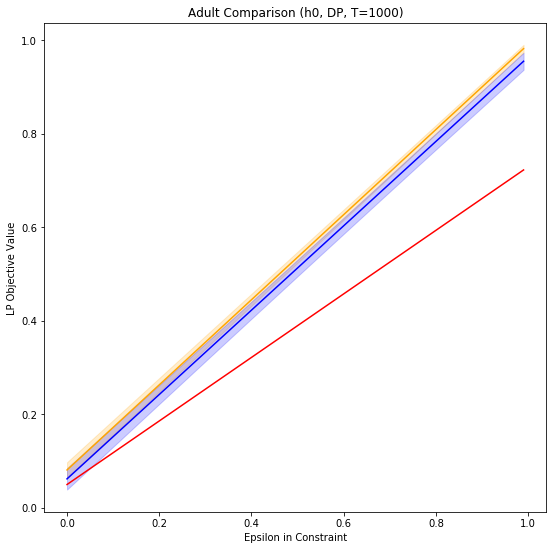

In [21]:
# Plot the constraints vs. objective values
plt.figure(figsize=(9,9))
plt.plot(epsilons, inprocessing_avg_objective_values, 'orange')
plt.plot(epsilons, postprocessing_avg_objective_values, 'blue')
plt.plot(epsilons, robust_avg_objective_values, 'red')
plt.fill_between(epsilons, inprocessing_avg_objective_values - inprocessing_std_err, inprocessing_avg_objective_values + inprocessing_std_err, color='orange', alpha=0.2)
plt.fill_between(epsilons, postprocessing_avg_objective_values - postprocessing_std_err, postprocessing_avg_objective_values + postprocessing_std_err, color='blue', alpha=0.2)
plt.xlabel('Epsilon in Constraint')
plt.ylabel('LP Objective Value')
plt.title('Adult Comparison (h0, DP, T=1000)')

## Weighted Loss Linear Program

In [29]:
def weighted_loss_linear_prog(y_pred, y_test, a_indices, proportions, lower_bound, upper_bound, a, a_p):
    # Make sure constraint is within bounds
    assert(0 < lower_bound < 1)
    assert(0 < upper_bound < 1)
    
    # Loss vector 1{h(x) =/= y}
    loss_vec = y_pred - y_test
    loss_vec[loss_vec < 0] = 1
    
    # Setup variables and subgp names
    n = len(y_pred)
    w = cp.Variable(n)
    
    # Setup subgroup proportions
    pi_a = proportions[a]
    pi_a_p = proportions[a_p]
    
    # Set constraints
    constraints = [
        cp.sum(w[a_indices[a]]) == pi_a,
        cp.sum(w[a_indices[a_p]]) == pi_a_p,
        cp.sum(w) == 1,
        0 <= w,
        lower_bound <= w,
        w <= upper_bound
    ]
    
    # Setup objective and problem
    objective = cp.Maximize(w @ loss_vec)
    problem = cp.Problem(objective, constraints)
    
    # Solve problem
    problem.solve(solver = 'ECOS')
    return problem.value, w.value

In [37]:
epsilon_granule = 0.01

inprocessing_objective_values_loss = []
postprocessing_objective_values_loss = []
robust_objective_values_loss = []

# Iterate over datasets
for s in range(5):
    proportions_test = proportions_test_arr[s]
    a_indices_test = a_indices_test_arr[s]
    inprocessing_y_pred = inprocessing_preds[s]
    postprocessing_y_pred = postprocessing_preds[s]
    y_test = y_test_arr[s]
    
    inprocessing_curr = []
    postprocessing_curr = []
    # Iterate over constraints
    for i in range(0, int(1/epsilon_granule)):
        epsilon = epsilon_granule * i
        lower_bound = (1 - epsilon)/(len(X_test))
        upper_bound = (1 + epsilon)/(len(X_test))

        inprocessing_objective_value_a0a1, w = weighted_loss_linear_prog(inprocessing_y_pred, y_test, a_indices_test, proportions_test, lower_bound, upper_bound, 'a0', 'a1')
        inprocessing_objective_value_a1a0, w = weighted_loss_linear_prog(inprocessing_y_pred, y_test, a_indices_test, proportions_test, lower_bound, upper_bound, 'a1', 'a0')
        inprocessing_objective_value = max(inprocessing_objective_value_a0a1, inprocessing_objective_value_a1a0)
        inprocessing_curr.append(inprocessing_objective_value)

        postprocessing_objective_value_a0a1, w = weighted_loss_linear_prog(postprocessing_y_pred, y_test, a_indices_test, proportions_test, lower_bound, upper_bound, 'a0', 'a1')
        postprocessing_objective_value_a1a0, w = weighted_loss_linear_prog(postprocessing_y_pred, y_test, a_indices_test, proportions_test, lower_bound, upper_bound, 'a1', 'a0')
        postprocessing_objective_value = max(postprocessing_objective_value_a0a1, postprocessing_objective_value_a1a0)
        postprocessing_curr.append(postprocessing_objective_value)
    
    inprocessing_objective_values_loss.append(np.asarray(inprocessing_curr))
    postprocessing_objective_values_loss.append(np.asarray(postprocessing_curr))
    
for i in range(0, int(1/epsilon_granule)):
    epsilon = epsilon_granule * i
    lower_bound = (1 - epsilon)/(len(X_test))
    upper_bound = (1 + epsilon)/(len(X_test))

    robust_objective_value_a0a1, w = weighted_loss_linear_prog(robust_pred, y_test_arr[0], a_indices_test, proportions_test, lower_bound, upper_bound, 'a0', 'a1')
    robust_objective_value_a1a0, w = weighted_loss_linear_prog(robust_pred, y_test_arr[0], a_indices_test, proportions_test, lower_bound, upper_bound, 'a1', 'a0')
    print(robust_objective_value_a1a0)
    print(robust_objective_value_a0a1)
    robust_objective_value = max(robust_objective_value_a0a1, robust_objective_value_a1a0)
    robust_objective_values_loss.append(robust_objective_value)

0.2549504950576917
0.2549504950576917
0.2575000000092946
0.2575000000092946
0.26004950495752
0.26004950495752
0.26259900990575946
0.26259900990575946
0.2651485148549152
0.2651485148549152
0.26769801980470076
0.26769801980470076
0.27024752475470754
0.27024752475470754
0.2727970297048736
0.2727970297048736
0.27534653465514236
0.27534653465514236
0.27789603960547693
0.27789603960547693
0.2804455445558808
0.2804455445558808
0.2829950495063999
0.2829950495063999
0.28554455445689486
0.28554455445689486
0.2880940594073607
0.2880940594073607
0.29064356435780586
0.29064356435780586
0.29319306930823114
0.29319306930823114
0.295742574258645
0.295742574258645
0.29829207920905426
0.29829207920905426
0.30084158415945894
0.30084158415945894
0.30339108910986595
0.30339108910986595
0.3059405940602742
0.3059405940602742
0.3084900990106829
0.3084900990106829
0.31103960396109803
0.31103960396109803
0.3135891089115354
0.3135891089115354
0.31613861386216
0.31613861386216
0.31868811881278064
0.31868811881278

In [31]:
epsilons = []
for i in range(0, int(1/epsilon_granule)):
    epsilons.append(i * epsilon_granule)

In [32]:
# Average over the results
inprocessing_avg_objective_values_loss = np.zeros(len(inprocessing_objective_values_loss[0]))
postprocessing_avg_objective_values_loss = np.zeros(len(postprocessing_objective_values_loss[0]))

for i in range(5):
    inprocessing_avg_objective_values_loss += inprocessing_objective_values_loss[i]
    postprocessing_avg_objective_values_loss += postprocessing_objective_values_loss[i]
    
inprocessing_avg_objective_values_loss = np.divide(inprocessing_avg_objective_values_loss, 5)
postprocessing_avg_objective_values_loss = np.divide(postprocessing_avg_objective_values_loss, 5)
robust_avg_objective_values_loss = robust_objective_values_loss

In [33]:
inprocessing_std_err = []
postprocessing_std_err = []

for i in range(100):
    inprocessing_vals = []
    postprocessing_vals = []
    
    for s in range(5):
        inprocessing_vals.append(inprocessing_objective_values_loss[s][i])
        postprocessing_vals.append(postprocessing_objective_values_loss[s][i])
        
    inprocessing_std_err.append(std_error(inprocessing_vals))
    postprocessing_std_err.append(std_error(postprocessing_vals))

Text(0.5, 1.0, 'Adult Comparison (h0, Weighted Loss, T=1000)')

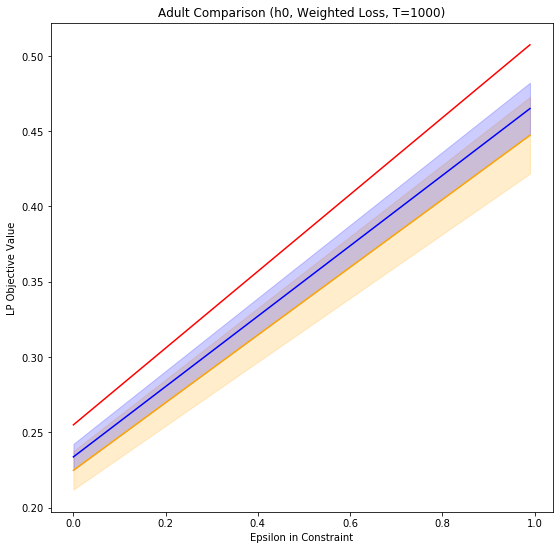

In [34]:
# Plot the constraints vs. objective values
plt.figure(figsize=(9,9))
plt.plot(epsilons, inprocessing_avg_objective_values_loss, 'orange')
plt.plot(epsilons, postprocessing_avg_objective_values_loss, 'blue')
plt.plot(epsilons, robust_avg_objective_values_loss, 'red')
plt.fill_between(epsilons, inprocessing_avg_objective_values_loss - inprocessing_std_err, inprocessing_avg_objective_values_loss + inprocessing_std_err, color='orange', alpha=0.2)
plt.fill_between(epsilons, postprocessing_avg_objective_values_loss - postprocessing_std_err, postprocessing_avg_objective_values_loss + postprocessing_std_err, color='blue', alpha=0.2)
plt.xlabel('Epsilon in Constraint')
plt.ylabel('LP Objective Value')
plt.title('Adult Comparison (h0, Weighted Loss, T=1000)')

In [39]:
postprocessing_avg_objective_values_loss

array([0.23366337, 0.236     , 0.23833663, 0.24067327, 0.2430099 ,
       0.24534653, 0.24768317, 0.2500198 , 0.25235644, 0.25469307,
       0.2570297 , 0.25936634, 0.26170297, 0.2640396 , 0.26637624,
       0.26871287, 0.2710495 , 0.27338614, 0.27572277, 0.27805941,
       0.28039604, 0.28273267, 0.28506931, 0.28740594, 0.28974257,
       0.29207921, 0.29441584, 0.29675248, 0.29908911, 0.30142574,
       0.30376238, 0.30609901, 0.30843564, 0.31077228, 0.31310891,
       0.31544554, 0.31778218, 0.32011881, 0.32245545, 0.32479208,
       0.32712871, 0.32946535, 0.33180198, 0.33413861, 0.33647525,
       0.33881188, 0.34114851, 0.34348515, 0.34582178, 0.34815842,
       0.35049505, 0.35283168, 0.35516832, 0.35750495, 0.35984158,
       0.36217822, 0.36451485, 0.36685149, 0.36918812, 0.37152475,
       0.37386139, 0.37619802, 0.37853465, 0.38087129, 0.38320792,
       0.38554455, 0.38788119, 0.39021782, 0.39255446, 0.39489109,
       0.39722772, 0.39956436, 0.40190099, 0.40423762, 0.40657